# 2. Calculate travel times

This stage computes the travel times from all the points of a three-dimensional grid to each seismic station. The travel times grid allows for shifting the data according to every tested point source point in the beamforming response calculation.

This tutorial utilizes the `PyKonal` package to compute travel times in a space-dependant velocity medium. The package documentation and installation procedure are described in the [PyKonal package documentation](https://github.com/malcolmw/pykonal). Please acknowledge [White et al. (2020)](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/91/4/2378/586804/PyKonal-A-Python-Package-for-Solving-the-Eikonal?redirectedFrom=fulltext) if using the package.

> **Note:** although `PyKonal` helps calculating the travel times in a three-dimensional velocity model, the example below uses a one-dimensional velocity model.

In [327]:
import numpy as np
import os
import pandas as pd
import tqdm
import xarray as xr

from matplotlib import pyplot as plt

from obspy import read, read_inventory
from pykonal.solver import PointSourceSolver
from pykonal.transformations import geo2sph, sph2geo

## Read velocity model

We downloaded the velocity model of [Karabulut et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0040195111002903?casa_token=wTzEUe0IdicAAAAA:fYbKmGkHHrQfyLicd0lO4Ai451jT6h_yTF6ZZXrvglpw9rXDTVVzWzIWNQ0aFAFbMJ_pU6I) and accessed with `pandas`. The model is given in meters for the depth and in m/s for the speed values. Everything is converted to km for the later compatibility with `pykonal`. 

In [328]:
FILEPATH_VELOCITY = "../data/velocity_model_Karabulut2011.csv"

We use pandas to read the velocity model. This allows using `xarray` for building the 3D model.

In [329]:
# Read velocity model
velocity_layers = pd.read_csv(
    FILEPATH_VELOCITY, 
    usecols=[1, 2, 4],
    names=["depth", "P", "S"],
    skiprows=1,
    index_col="depth",
    )

# Convert meters to kilometers
velocity_layers *= 1e-3
velocity_layers.index *= 1e-3

# Show table
velocity_layers.T

depth,-2.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,8.0,10.0,12.0,14.0,15.0,20.0,22.0,25.0,32.0,77.0
P,2.90,3.0,5.60,5.70,5.80,5.90,5.95,6.05,6.10,6.15,6.20,6.25,6.30,6.40,6.50,6.70,8.00,8.045
S,1.67,1.9,3.15,3.21,3.26,3.41,3.42,3.44,3.48,3.56,3.59,3.61,3.63,3.66,3.78,3.85,4.65,4.650


<AxesSubplot:title={'center':'1D velocity model in the Marmara region'}, xlabel='Depth (km)', ylabel='Speed (km/s)'>

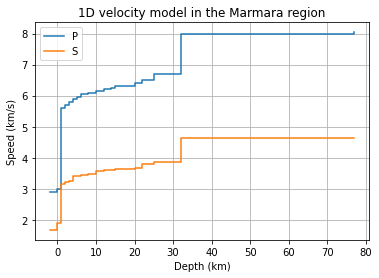

In [330]:
velocity_layers.plot(
    drawstyle="steps-post",
    ylabel="Speed (km/s)",
    xlabel="Depth (km)",
    title="1D velocity model in the Marmara region",
    grid=True,
)


## Interpolate velocity model at depth

We calculate the travel times on a finer grid than the model grid, so we need to interpolate the model. We do so while keeping the layer aspect of the model (last-value constant interpolation).

In [331]:
depths = np.linspace(30.0, -2.0, 20)

velocity_layers_interp = velocity_layers.reindex(depths, method="ffill")

Compare the natural (layered) and interpolated models.

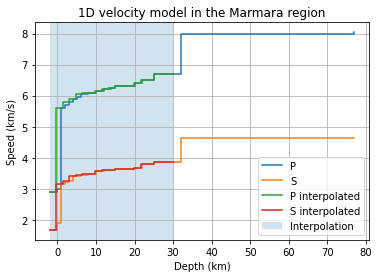

In [332]:
velocity_layers.plot(drawstyle="steps-post")
velocity_layers_interp.plot(
    drawstyle="steps-post",
    xlabel="Depth (km)",
    ylabel="Speed (km/s)",
    title="1D velocity model in the Marmara region",
    ax=plt.gca(),
    grid=True,
)

# Interpolation depth range
plt.axvspan(depths.min(), depths.max(), alpha=0.2, label="Interpolation range")
plt.legend(["P", "S", "P interpolated", "S interpolated", "Interpolation"])

## Expand model laterally

Because the overall package works in full three-dimensional coordinates, we tile the velocity model into a three-dimensional one. We do that by replicating the 1D along longitude and latitude dimensions with `xarray`.

In [333]:
longitudes = np.linspace(30.20, 30.45, 40)
latitudes = np.linspace(40.60, 40.76, 35)

# Xarray
velocities = velocity_layers_interp.stack().to_xarray()
velocities = velocities.rename({"level_1": "phase"})

# Add longitudes and latitude dimensions (automatically tiles)
velocities = velocities.expand_dims(latitude=latitudes, longitude=longitudes)

## Station coordinates

**Note:** we use the inventory handler of obspy to gather the station coordinates. The `.get_coordinates()` method of the `inventory` object needs a `seed_id` to capture the response or coordinates of a given stream at a given station state in time. This cell gets the first entry of that inventory, noting that for more advanced application this should be handled with care.

In [334]:
# Get inventories
inventory = read_inventory("../data/processed/*xml")

# Extract stations
stations = [sta for net in inventory for sta in net]
attrs = "longitude", "latitude", "elevation", "code"
stations = [{item: getattr(sta, item) for item in attrs} for sta in stations]

# Turn into dataframe
network = pd.DataFrame(stations).set_index("code")
network["depth"] = -1e-3 * network.elevation 

# Show
network


,longitude,latitude,elevation,depth
code,,,,
DC06,30.265751,40.616718,555.0,-0.555
DC07,30.242170,40.667080,164.0,-0.164
DC08,30.250130,40.744438,162.0,-0.162
DD06,30.317770,40.623539,182.0,-0.182
DE07,30.411539,40.679661,40.0,-0.040
DE08,30.406469,40.748562,31.0,-0.031
SAUV,30.327200,40.740200,170.0,-0.170
SPNC,30.308300,40.686001,190.0,-0.190


## Show model and stations

Give an overview of the input data.

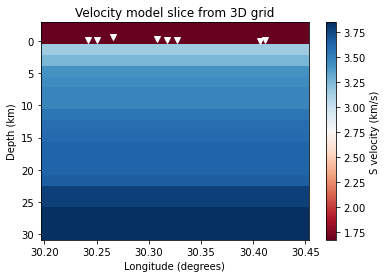

In [335]:
# Select slice at first latitude index
velocities_slice = velocities.sel(phase="S", latitude=latitudes.min())

# Show velocities
img = velocities_slice.T.plot.imshow(cmap="RdBu", add_colorbar=False)

# Show stations
plt.plot(network.longitude, network.depth, "wv")

# Labels
ax = plt.gca()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title("Velocity model slice from 3D grid")
ax.invert_yaxis()
cb = plt.colorbar(img)
cb.set_label(f"{velocities_slice.phase.data} velocity (km/s)")

# Show
plt.show()


## Calculate travel times and save

The travel times are calculated for every station with the Eikonal solver of the `pykonal` package. The travel times are then saved into a `h5` file for later use. 

**Warning**: Geographical coordinate system are consider in the $(\lambda, \phi, z)$ order, while the spherical coordinate system uses $(r, \theta, \varphi)$, where $\theta$ and $\varphi$ are in radians, and where $\theta$ is the colatitude, $\lambda$ the latitude and $\phi$ and $\varphi$ are longitudes. The depth $z$ in oriented towards the Earth center, the radial component $r$ outward. 

In [336]:
FILEPATH_TRAVELTIMES = "../data/travel_times.nc"
STATION_ENTRIES = ["latitude", "longitude", "depth"]

# Initiliaze travel times
velocities = velocities.transpose("phase", "depth", "latitude", "longitude")
travel_times = velocities.copy()
travel_times = travel_times.expand_dims(station=network.index).copy()

# Reference point
reference_point = geo2sph((latitudes.max(), longitudes.min(), depths.max()))
node_intervals = (
    np.abs(depths[1] - depths[0]),
    np.deg2rad(latitudes[1] - latitudes[0]),
    np.deg2rad(longitudes[1] - longitudes[0]),
)

# Loop over stations and phases
for phase in travel_times.phase.data:
    for station in tqdm.tqdm(network.index, desc=f"Travel times {phase}"):

        # Initialize Eikonal solver
        solver = PointSourceSolver(coord_sys="spherical")
        solver.velocity.min_coords = reference_point
        solver.velocity.node_intervals = node_intervals

        # Velocity
        velocity = velocities.sel(phase=phase)[:, ::-1]
        solver.velocity.npts = velocity.shape
        solver.velocity.values = velocity.copy()

        # Source
        src_loc = network.loc[station][STATION_ENTRIES].values
        solver.src_loc = geo2sph(src_loc).squeeze()

        # Solve Eikonal equation
        solver.solve()

        # Assign to dataarray (flip back for depth convention)
        locator = dict(station=station, phase=phase)
        travel_times.loc[locator] = solver.tt.values[:, ::-1]

Travel times S: 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]


Save the travel times as NetCDF file.

In [337]:
travel_times.to_netcdf(FILEPATH_TRAVELTIMES)

## Show travel times at a given station

The travel times are calculated for every station with the Eikonal solver of the `pykonal` package. The travel times are then saved into a `h5` file for later use.

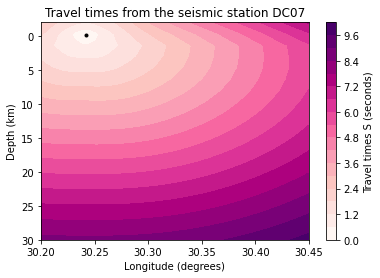

In [338]:
CONTOUR_LEVELS = 20
SEISMIC_PHASE = "S"
station = network.loc["DC07"]

# Show
latitude_id = np.abs(travel_times.latitude - station.latitude).argmin()
time_delays = travel_times.sel(phase=SEISMIC_PHASE, station=station.name)
time_delays = time_delays.isel(latitude=latitude_id)
img = time_delays.plot.contourf(
    add_colorbar=False, cmap="RdPu", levels=CONTOUR_LEVELS
)

# Colorbar
cb = plt.colorbar(img)
cb.set_label(f"Travel times {SEISMIC_PHASE} (seconds)")

# Station
plt.plot(station.longitude, station.depth, "k.")

# Labels
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title(f"Travel times from the seismic station {station.name}")
plt.show()
